# Electric Vehicle Charging Optimization Using Pyomo Framework

## Table of Contents
1. [Introduction](#introduction)
2. [Problem Formulation](#problem-formulation)
3. [Mathematical Model](#mathematical-model)
4. [Implementation](#implementation)
5. [Real Data Analysis](#real-data-analysis)
6. [Results and Discussion](#results-and-discussion)

---
## 1. Introduction {#introduction}

This tutorial demonstrates how to formulate and solve an EV charging optimization problem using Pyomo framework and compatibale solvers (i.e., CBC, Gurobi).

### Key Objectives:
- **Minimize total electricity costs** (energy charges + demand charges)
- **Satisfy charging requirements** for all EV sessions
- **Satisfy charging limits** for all charging stations (L1, L2, and L3)


In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# EVChargingOptimizer Class Definition
class EVChargingOptimizer:
    """
    Mixed Integer Linear Programming optimizer for EV charging sessions
    to minimize energy costs using 15-minute time steps.
    """
    
    def __init__(self, start_date: str = "2017-08-01"):
        """
        Initialize the optimizer with time parameters and rate structure.
        
        Args:
            start_date: Start date for optimization (YYYY-MM-DD format)
        """
        self.start_date = datetime.strptime(start_date, "%Y-%m-%d")
        self.time_step_minutes = 15
        self.optimization_horizon_hours = 32  # Until (day+1) 08:00
        self.total_time_slots = int(self.optimization_horizon_hours * 60 / self.time_step_minutes)
        
        # L2 Charging Station Continuous Power Range. Can be adjusted based on station capabilities.
        # These values are typical for Level 2 charging stations.
        self.min_power = 1.2  # kW: Minimum power level
        self.max_power = 7.0  # kW: Maximum power level
        
        # Create time slots from start_date 00:00 to next day 08:00
        self.time_slots = []
        current_time = self.start_date
        for i in range(self.total_time_slots):
            self.time_slots.append(current_time)
            current_time += timedelta(minutes=self.time_step_minutes)
        
        # Define rate structure based on PG&E E-19
        self.setup_rate_structure()
        
        print(f"Optimizer initialized for {start_date}")
        print(f"L2 Charging Station Power Range: {self.min_power} - {self.max_power} kW (Continuous)")
        print(f"Optimization period: {self.total_time_slots} time slots (15-min each)")
        print(f"Rate period: {'Summer' if self.is_summer else 'Winter'}")
        
    def setup_rate_structure(self):
        """Setup energy and demand charge rates based on PG&E E-19 schedule."""
        # Determine if summer or winter period
        month = self.start_date.month
        is_summer = month >= 5 and month <= 10
        
        if is_summer:
            # Summer rates (May 1 - Oct 31)
            self.energy_rates = {
                'peak': 0.14726,      # 12:00 PM - 6:00 PM
                'part_peak': 0.10714, # 8:30 AM-12:00 PM, 6:00 PM-9:30 PM
                'off_peak': 0.08057   # All other times
            }
            self.demand_rates = {
                'peak': 18.74,        # 12:00 PM - 6:00 PM
                'part_peak': 5.23,    # 8:30 AM-12:00 PM, 6:00 PM-9:30 PM
                'anytime': 17.33      # Any time
            }
        else:
            # Winter rates (Nov 1 - Apr 30)
            self.energy_rates = {
                'part_peak': 0.10166, # 8:30 AM - 9:30 PM
                'off_peak': 0.08717   # All other times
            }
            self.demand_rates = {
                'part_peak': 0.13,    # 8:30 AM - 9:30 PM
                'anytime': 17.33      # Any time
            }
        
        self.is_summer = is_summer
        
    def get_time_period(self, time_slot: datetime) -> str:
        """Determine the time-of-use period for a given time slot."""
        hour = time_slot.hour
        minute = time_slot.minute
        time_decimal = hour + minute / 60.0
        
        if self.is_summer:
            # Summer periods
            if 12.0 <= time_decimal < 18.0:  # 12:00 PM - 6:00 PM
                return 'peak'
            elif (8.5 <= time_decimal < 12.0) or (18.0 <= time_decimal < 21.5):
                return 'part_peak'
            else:
                return 'off_peak'
        else:
            # Winter periods
            if 8.5 <= time_decimal < 21.5:  # 8:30 AM - 9:30 PM
                return 'part_peak'
            else:
                return 'off_peak'



In [ ]:
def load_charging_sessions(self, data: List[Dict]) -> pd.DataFrame:
    """
    Load and process charging session data for flexible L2 charging.
    
    Args:
        data: List of dictionaries with keys: 'event_id', 'start_time', 'end_time', 'energy_kwh'
    
    Returns:
        DataFrame with processed charging session data
    """
    sessions = []
    optimization_end_time = self.start_date + timedelta(hours=self.optimization_horizon_hours)
    
    for session in data:
        # Convert string times to datetime if needed
        if isinstance(session['start_time'], str):
            start_time = datetime.strptime(session['start_time'], "%Y-%m-%d %H:%M:%S")
        else:
            start_time = session['start_time']
            
        if isinstance(session['end_time'], str):
            end_time = datetime.strptime(session['end_time'], "%Y-%m-%d %H:%M:%S")
        else:
            end_time = session['end_time']
        
        # Skip sessions that don't overlap with optimization period
        if end_time <= self.start_date or start_time >= optimization_end_time:
            continue
            
        # Skip sessions with zero or negative energy
        if session['energy_charged_kWh'] <= 0:
            continue
        
        # Constrain session times to optimization window
        constrained_start = max(start_time, self.start_date)
        constrained_end = min(end_time, optimization_end_time)
        
        # Calculate session duration
        duration_hours = (end_time - start_time).total_seconds() / 3600
        session_duration_slots = int((constrained_end - constrained_start).total_seconds() / (self.time_step_minutes * 60))
        
        # Calculate minimum time needed for charging
        time_step_hours = self.time_step_minutes / 60
        min_time_needed_hours = session['energy_charged_kWh'] / self.max_power  # Using maximum power
        min_slots_needed = int(np.ceil(min_time_needed_hours / time_step_hours))
        
        # Check if session can be satisfied within time window
        if min_slots_needed > session_duration_slots:
            print(f"Warning: Session {session['event_id']} cannot be satisfied within time window")
            continue
        
        # Determine time slot indices
        start_slot = max(0, int((constrained_start - self.start_date).total_seconds() / (self.time_step_minutes * 60)))
        end_slot = min(self.total_time_slots - 1, 
                      int((constrained_end - self.start_date).total_seconds() / (self.time_step_minutes * 60)))
        
        # Skip sessions that are too short
        if end_slot <= start_slot:
            continue
        
        sessions.append({
            'event_id': session['Plug In Event Id'],
            'start_time': start_time,
            'end_time': end_time,
            'constrained_start': constrained_start,
            'constrained_end': constrained_end,
            'energy_kwh': session['energy_charged_kWh'],
            'start_slot': start_slot,
            'end_slot': end_slot,
            'duration_hours': duration_hours,
            'min_slots_needed': min_slots_needed,
            'session_duration_slots': session_duration_slots,
            'min_completion_time': start_slot + min_slots_needed - 1,
            'latest_start_slot': end_slot - min_slots_needed + 1
        })
    
    return pd.DataFrame(sessions)

# Add method to the class
EVChargingOptimizer.load_charging_sessions = load_charging_sessions

print("Add Data loading functions.")

Add Data loading functions!


In [8]:
# MILP Model Creation with Pyomo
def create_milp_model(self, sessions_df: pd.DataFrame) -> Tuple[pyo.ConcreteModel, Dict]:
    """
    Create the Mixed Integer Linear Programming model for flexible charging optimization
    with continuous L2 power levels using Pyomo framework.
    
    Args:
        sessions_df: DataFrame with charging session data
    
    Returns:
        Tuple of (Pyomo model, variable reference dictionary)
    """
    print("Creating MILP model with Pyomo framework...")
    print(f"Sessions to optimize: {len(sessions_df)}")
    print(f"Time slots: {self.total_time_slots}")
    print(f"Power range: {self.min_power} - {self.max_power} kW (Continuous)")
    
    # Create the Pyomo model
    model = pyo.ConcreteModel()
    
    # Sets
    model.sessions = pyo.Set(initialize=[row['event_id'] for _, row in sessions_df.iterrows()])
    model.time_slots = pyo.Set(initialize=range(self.total_time_slots))
    
    # Parameters
    model.min_power = pyo.Param(initialize=self.min_power)
    model.max_power = pyo.Param(initialize=self.max_power)
    model.time_step_hours = pyo.Param(initialize=self.time_step_minutes / 60)
    
    # Session parameters
    session_energy = {}
    session_start_slot = {}
    session_end_slot = {}
    
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        session_energy[session_id] = session['energy_kwh']
        session_start_slot[session_id] = session['start_slot']
        session_end_slot[session_id] = session['end_slot']
    
    model.session_energy = pyo.Param(model.sessions, initialize=session_energy)
    model.session_start_slot = pyo.Param(model.sessions, initialize=session_start_slot)
    model.session_end_slot = pyo.Param(model.sessions, initialize=session_end_slot)
    
    # Time-of-use energy rates
    energy_rates = {}
    for t in model.time_slots:
        time_slot = self.time_slots[t]
        period = self.get_time_period(time_slot)
        energy_rates[t] = self.energy_rates[period]
    
    model.energy_rate = pyo.Param(model.time_slots, initialize=energy_rates)
    
    # Decision Variables
    # Binary charging indicator: x[session_id, time_slot]
    model.x = pyo.Var(model.sessions, model.time_slots, domain=pyo.Binary)
    
    # Continuous power level: P[session_id, time_slot]
    model.P = pyo.Var(model.sessions, model.time_slots, bounds=(0, self.max_power))
    
    # Demand charge variables
    if self.is_summer:
        model.max_peak_demand = pyo.Var(bounds=(0, None))
        model.max_part_peak_demand = pyo.Var(bounds=(0, None))
    else:
        model.max_part_peak_demand = pyo.Var(bounds=(0, None))
    model.max_anytime_demand = pyo.Var(bounds=(0, None))
    
    total_vars = len(model.sessions) * len(model.time_slots) * 2  # x and P variables
    if self.is_summer:
        total_vars += 3  # demand variables
    else:
        total_vars += 2
    
    print(f"Created {total_vars} decision variables")
    
    # Objective Function: Minimize total cost (energy + demand charges)
    def objective_rule(model):
        energy_cost = sum(model.P[i, t] * model.time_step_hours * model.energy_rate[t]
                         for i in model.sessions for t in model.time_slots)
        
        demand_cost = 0
        if self.is_summer:
            demand_cost += model.max_peak_demand * self.demand_rates['peak']
            demand_cost += model.max_part_peak_demand * self.demand_rates['part_peak']
        else:
            demand_cost += model.max_part_peak_demand * self.demand_rates['part_peak']
        demand_cost += model.max_anytime_demand * self.demand_rates['anytime']
        
        return energy_cost + demand_cost
    
    model.objective = pyo.Objective(rule=objective_rule, sense=pyo.minimize)
    
    print("Adding constraints...")
    
    # Constraint 1: Power level bounds
    def power_lower_bound_rule(model, i, t):
        return model.P[i, t] >= model.min_power * model.x[i, t]
    
    def power_upper_bound_rule(model, i, t):
        return model.P[i, t] <= model.max_power * model.x[i, t]
    
    model.power_lower_bound = pyo.Constraint(model.sessions, model.time_slots, 
                                           rule=power_lower_bound_rule)
    model.power_upper_bound = pyo.Constraint(model.sessions, model.time_slots, 
                                           rule=power_upper_bound_rule)
    
    # Constraint 2: Time window constraints
    def time_window_rule(model, i, t):
        if t < model.session_start_slot[i] or t > model.session_end_slot[i]:
            return model.x[i, t] == 0
        else:
            return pyo.Constraint.Skip
    
    model.time_window = pyo.Constraint(model.sessions, model.time_slots, 
                                     rule=time_window_rule)
    
    # Constraint 3: Energy requirement constraints
    def energy_requirement_rule(model, i):
        return sum(model.P[i, t] * model.time_step_hours for t in model.time_slots) == model.session_energy[i]
    
    model.energy_requirement = pyo.Constraint(model.sessions, rule=energy_requirement_rule)
    
    # Constraint 4: Demand charge constraints
    def max_peak_demand_rule(model, t):
        if self.is_summer:
            time_slot = self.time_slots[t]
            period = self.get_time_period(time_slot)
            if period == 'peak':
                return model.max_peak_demand >= sum(model.P[i, t] for i in model.sessions)
        return pyo.Constraint.Skip
    
    def max_part_peak_demand_rule(model, t):
        time_slot = self.time_slots[t]
        period = self.get_time_period(time_slot)
        if period == 'part_peak':
            return model.max_part_peak_demand >= sum(model.P[i, t] for i in model.sessions)
        return pyo.Constraint.Skip
    
    def max_anytime_demand_rule(model, t):
        return model.max_anytime_demand >= sum(model.P[i, t] for i in model.sessions)
    
    if self.is_summer:
        model.max_peak_demand_constraint = pyo.Constraint(model.time_slots, rule=max_peak_demand_rule)
    model.max_part_peak_demand_constraint = pyo.Constraint(model.time_slots, rule=max_part_peak_demand_rule)
    model.max_anytime_demand_constraint = pyo.Constraint(model.time_slots, rule=max_anytime_demand_rule)
    
    # Count constraints
    constraint_count = 0
    constraint_count += len(model.sessions) * len(model.time_slots) * 2  # Power bounds
    constraint_count += len(model.sessions)  # Energy requirements
    constraint_count += len(model.time_slots)  # Anytime demand
    if self.is_summer:
        constraint_count += len(model.time_slots)  # Peak demand
    constraint_count += len(model.time_slots)  # Part-peak demand
    
    # Add time window constraints (only for slots outside session windows)
    for _, session in sessions_df.iterrows():
        session_id = session['event_id']
        start_slot = session['start_slot']
        end_slot = session['end_slot']
        for t in range(self.total_time_slots):
            if t < start_slot or t > end_slot:
                constraint_count += 1
    
    print(f"Added approximately {constraint_count} constraints")
    
    # Create variable reference dictionary for compatibility
    variables = {
        'model': model,
        'charge_vars': model.x,
        'power_vars': model.P,
        'demand_vars': {
            'anytime': model.max_anytime_demand
        }
    }
    
    if self.is_summer:
        variables['demand_vars']['peak'] = model.max_peak_demand
        variables['demand_vars']['part_peak'] = model.max_part_peak_demand
    else:
        variables['demand_vars']['part_peak'] = model.max_part_peak_demand
    
    return model, variables

# Add method to the class
EVChargingOptimizer.create_milp_model = create_milp_model

print("MILP model creation function defined.")

MILP model creation function defined.


## 5. Real Data Analysis {#real-data-analysis}

Load and analyze the real charging session data from August 1, 2017.

In [9]:
# Load and Analyze Real Data
# Initialize the optimizer
optimizer = EVChargingOptimizer(start_date="2017-08-01")

# Load actual charging session data
print("Loading real charging session data...")

# Load the JSON data from the file or any other source
import json
with open(f'data/chapter5/extracted_data_{'2017-08-01'}.json', 'r') as f:
    actual_data = json.load(f)
sessions_df = optimizer.load_charging_sessions(actual_data)

print(f"\nDataset Summary:")
print(f"- Total sessions loaded: {len(actual_data)}")
print(f"- Sessions for optimization: {len(sessions_df)}")
print(f"- Total energy requirement: {sessions_df['energy_kwh'].sum():.1f} kWh")
print(f"- Average session energy: {sessions_df['energy_kwh'].mean():.1f} kWh")
print(f"- Average session duration: {sessions_df['duration_hours'].mean():.1f} hours")

# Display sample sessions
print(f"\nSample charging sessions:")
display_cols = ['event_id', 'start_time', 'end_time', 'energy_kwh', 
                'min_slots_needed', 'session_duration_slots', 'min_completion_time']
display_df = sessions_df[display_cols].head()
print(display_df.to_string())

print(f"\nFlexible L2 Charging Analysis:")
time_step_hours = 0.25  # 15 minutes
energy_per_slot_min = 1.2 * time_step_hours  # kWh per 15-min slot at 1.2 kW
energy_per_slot_max = 7.0 * time_step_hours  # kWh per 15-min slot at 7.0 kW

print(f"Energy per 15-min time slot range:")
print(f"  Minimum power (1.2 kW): {energy_per_slot_min:.2f} kWh")
print(f"  Maximum power (7.0 kW): {energy_per_slot_max:.2f} kWh")
print(f"  Flexible charging: Can charge at any time within session window")
print(f"  Early completion: Optimizer incentivized to complete ASAP")

# Check feasibility for each session
print(f"\nSession Feasibility & Completion Analysis:")
for _, session in sessions_df.head().iterrows():
    earliest_completion = session['start_slot'] + session['min_slots_needed'] - 1
    latest_start = session['end_slot'] - session['min_slots_needed'] + 1
    
    print(f"Session {session['event_id']}:")
    print(f"  Energy needed: {session['energy_kwh']:.2f} kWh")
    print(f"  Min slots needed: {session['min_slots_needed']} (using 7.0 kW)")
    print(f"  Available slots: {session['session_duration_slots']}")
    print(f"  Earliest completion: Slot {earliest_completion}")
    print(f"  Latest start allowed: Slot {latest_start}")
    print(f"  Flexibility: {session['session_duration_slots'] - session['min_slots_needed']} extra slots")
    print(f"  Feasible: {'✓' if session['min_slots_needed'] <= session['session_duration_slots'] else '✗'}")


Optimizer initialized for 2017-08-01
L2 Charging Station Power Range: 1.2 - 7.0 kW (Continuous)
Optimization period: 128 time slots (15-min each)
Rate period: Summer
Loading real charging session data...

Dataset Summary:
- Total sessions loaded: 30
- Sessions for optimization: 29
- Total energy requirement: 271.4 kWh
- Average session energy: 9.4 kWh
- Average session duration: 12.0 hours

Sample charging sessions:
   event_id          start_time            end_time  energy_kwh  min_slots_needed  session_duration_slots  min_completion_time
0  77344924 2017-08-01 19:15:00 2017-08-02 01:00:00    7.230203                 5                      23                   81
1  77340858 2017-08-01 18:15:00 2017-08-02 08:30:00   12.326301                 8                      55                   80
2  77339080 2017-08-01 18:00:00 2017-08-02 07:15:00    8.411539                 5                      53                   76
3  77336462 2017-08-01 17:30:00 2017-08-01 17:45:00    0.885824         

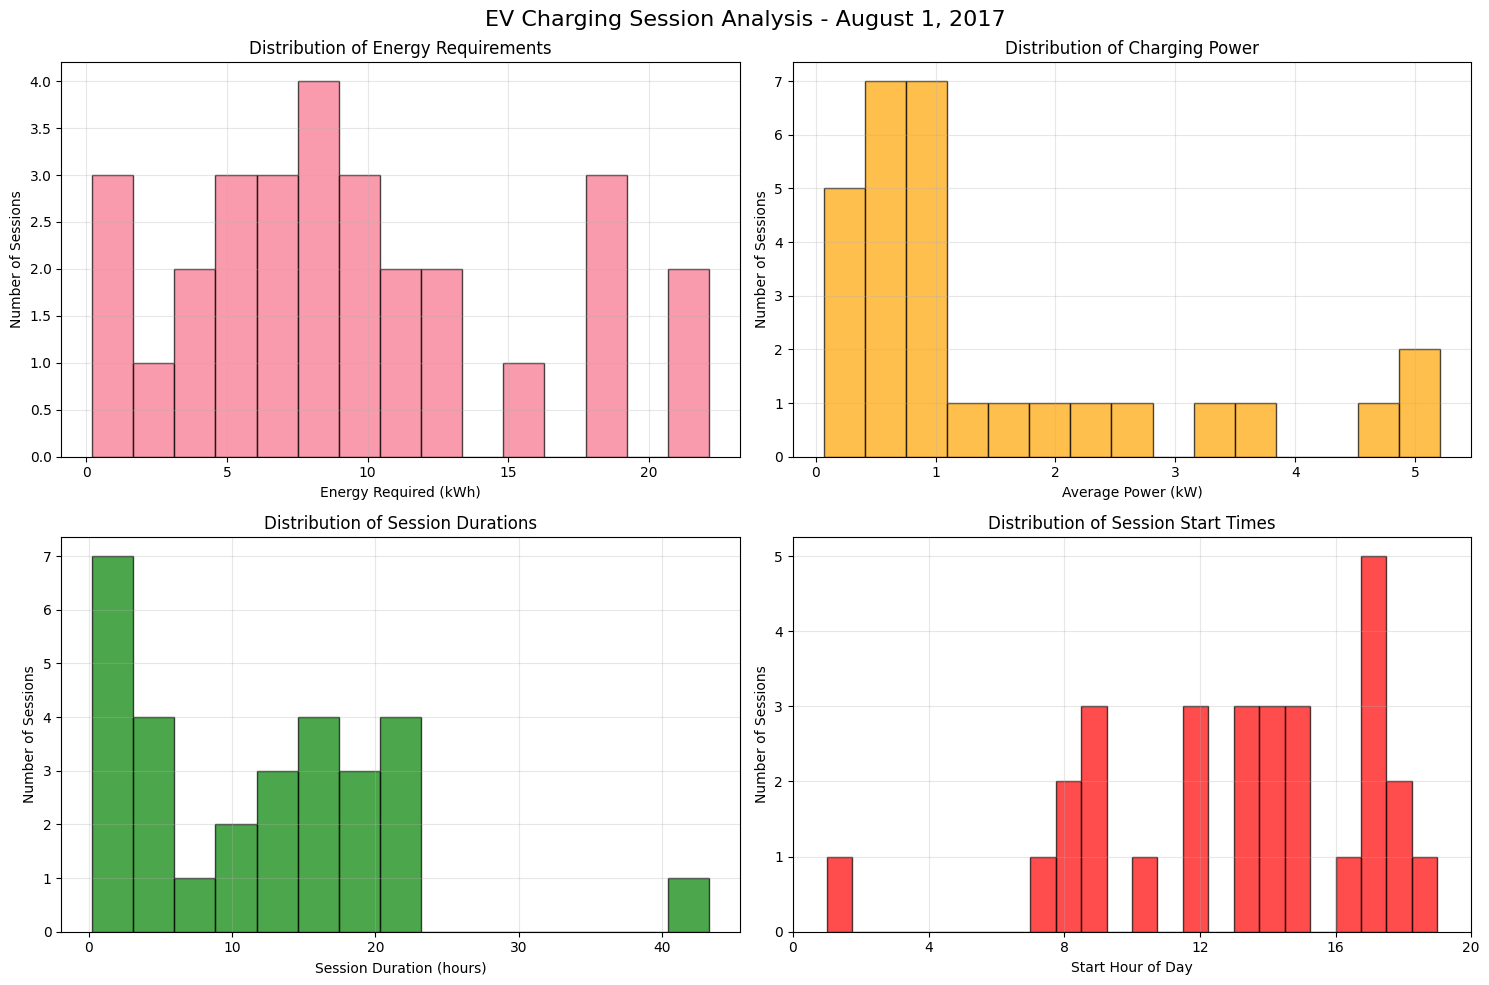

In [11]:
# Visualize Data Characteristics
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create subplots for data analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('EV Charging Session Analysis - August 1, 2017', fontsize=16)

# 1. Energy distribution
axes[0,0].hist(sessions_df['energy_kwh'], bins=15, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Energy Required (kWh)')
axes[0,0].set_ylabel('Number of Sessions')
axes[0,0].set_title('Distribution of Energy Requirements')
axes[0,0].grid(True, alpha=0.3)

# 2. Power distribution
axes[0,1].hist(sessions_df['energy_kwh']/sessions_df['duration_hours'], bins=15, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].set_xlabel('Average Power (kW)')
axes[0,1].set_ylabel('Number of Sessions')
axes[0,1].set_title('Distribution of Charging Power')
axes[0,1].grid(True, alpha=0.3)

# 3. Session duration
axes[1,0].hist(sessions_df['duration_hours'], bins=15, alpha=0.7, color='green', edgecolor='black')
axes[1,0].set_xlabel('Session Duration (hours)')
axes[1,0].set_ylabel('Number of Sessions')
axes[1,0].set_title('Distribution of Session Durations')
axes[1,0].grid(True, alpha=0.3)

# 4. Start time distribution
start_hours = [t.hour for t in sessions_df['start_time']]
axes[1,1].hist(start_hours, bins=24, alpha=0.7, color='red', edgecolor='black')
axes[1,1].set_xlabel('Start Hour of Day')
axes[1,1].set_ylabel('Number of Sessions')
axes[1,1].set_title('Distribution of Session Start Times')
axes[1,1].set_xticks(range(0, 24, 4))
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Results and Discussion {#results-and-discussion}

Solve the optimization problem and analyze the results.

**Note**: Due to the computational complexity of this MILP problem (28 sessions × ~60 charging blocks × 128 time slots), 
we'll solve with a subset of sessions for demonstration purposes. In practice, you might use:
- Commercial solvers (Gurobi, CPLEX) for better performance
- Rolling horizon optimization for larger datasets
- Heuristic algorithms for real-time applications

In [ ]:
# Solve Optimization with Pyomo, CBC solver is used if Gurobi is not available
def solve_optimization_demo(optimizer, sessions_df, max_sessions=3):
    """
    Solve optimization for flexible charging using Pyomo framework.
    """
    print(f"Solving optimization for first {max_sessions} sessions...")
    
    # Select subset for demonstration
    demo_sessions = sessions_df.head(max_sessions).copy()
    
    print(f"Demo dataset:")
    print(f"- Sessions: {len(demo_sessions)}")
    print(f"- Total energy: {demo_sessions['energy_kwh'].sum():.1f} kWh")
    print(f"- Min slots needed: {demo_sessions['min_slots_needed'].sum()}")
    print(f"- Power range: {optimizer.min_power} - {optimizer.max_power} kW (Continuous)")
    print(f"- Charging strategy: Flexible timing with cost minimization")
    
    # Create model
    model, variables = optimizer.create_milp_model(demo_sessions)
    
    print("\nSolving MILP model with Pyomo...")
    
    # Create solver
    solver = pyo.SolverFactory('cbc')  # CBC solver
    solver.options['seconds'] = 300  # 5 minute time limit

    # Solve the model
    results = solver.solve(model, tee=True)
    
    # Extract results
    optimization_results = {
        'status': None,
        'objective_value': None,
        'charging_schedule': {},
        'demand_charges': {},
        'total_demand_by_period': {}
    }
    
    # Check solver status
    if (results.solver.status == SolverStatus.ok and 
        results.solver.termination_condition == TerminationCondition.optimal):
        
        optimization_results['status'] = 'Optimal'
        optimization_results['objective_value'] = pyo.value(model.objective)
        
        print(f"Optimization successful!")
        print(f"Optimal objective: ${optimization_results['objective_value']:.2f}")
        
        # Extract charging schedule
        for _, session in demo_sessions.iterrows():
            session_id = session['event_id']
            optimization_results['charging_schedule'][session_id] = []
            
            for t in range(optimizer.total_time_slots):
                if pyo.value(model.x[session_id, t]) == 1:
                    power_level = pyo.value(model.P[session_id, t])
                    optimization_results['charging_schedule'][session_id].append({
                        'time_slot': t,
                        'time': optimizer.time_slots[t],
                        'power_kw': power_level,
                        'energy_kwh': power_level * (optimizer.time_step_minutes / 60)
                    })
        
        # Extract demand charges
        demand_vars = variables['demand_vars']
        for period, var in demand_vars.items():
            optimization_results['demand_charges'][period] = pyo.value(var)
            optimization_results['total_demand_by_period'][period] = pyo.value(var) * optimizer.demand_rates[period]
    
    elif results.solver.termination_condition == TerminationCondition.infeasible:
        optimization_results['status'] = 'Infeasible'
        print("Optimization failed: Problem is infeasible")
    elif results.solver.termination_condition == TerminationCondition.unbounded:
        optimization_results['status'] = 'Unbounded'
        print("Optimization failed: Problem is unbounded")
    elif results.solver.termination_condition == TerminationCondition.maxTimeLimit:
        optimization_results['status'] = 'Time Limit'
        print("Optimization stopped: Time limit reached")
        # Try to extract best solution found
        if hasattr(model, 'objective') and pyo.value(model.objective) is not None:
            optimization_results['objective_value'] = pyo.value(model.objective)
            print(f"Best solution found: ${optimization_results['objective_value']:.2f}")
    else:
        optimization_results['status'] = f"Failed: {results.solver.termination_condition}"
        print(f"Optimization failed with status: {results.solver.termination_condition}")
    
    return optimization_results, demo_sessions

# Run the optimization
results, demo_sessions = solve_optimization_demo(optimizer, sessions_df, max_sessions=3)


In [ ]:
# Solve Optimization with Pyomo, use Gurobi solver if available
def solve_optimization_demo(optimizer, sessions_df, max_sessions=10):
    """
    Solve optimization for flexible charging using Pyomo framework.
    """
    print(f"Solving optimization for first {max_sessions} sessions...")
    
    # Select subset for demonstration
    demo_sessions = sessions_df.head(max_sessions).copy()
    
    print(f"Demo dataset:")
    print(f"- Sessions: {len(demo_sessions)}")
    print(f"- Total energy: {demo_sessions['energy_kwh'].sum():.1f} kWh")
    print(f"- Min slots needed: {demo_sessions['min_slots_needed'].sum()}")
    print(f"- Power range: {optimizer.min_power} - {optimizer.max_power} kW (Continuous)")
    print(f"- Charging strategy: Flexible timing with cost minimization")
    
    # Create model
    model, variables = optimizer.create_milp_model(demo_sessions)
    
    print("\nSolving MILP model with Pyomo...")
    
    # Create solver, use gurobi solver
    solver = pyo.SolverFactory('gurobi')  # Gurobi solver

    # Set solver time limit (optional)
    # Uncomment the next line to set a time limit for the solver
    solver.options['TimeLimit'] = 300  # 5 minute time limit
    # solver.options['seconds'] = 300  # 5 minute time limit

    # Solve the model
    results = solver.solve(model, tee=True)
    
    # Extract results
    optimization_results = {
        'status': None,
        'objective_value': None,
        'charging_schedule': {},
        'demand_charges': {},
        'total_demand_by_period': {}
    }
    
    # Check solver status
    if (results.solver.status == SolverStatus.ok and 
        results.solver.termination_condition == TerminationCondition.optimal):
        
        optimization_results['status'] = 'Optimal'
        optimization_results['objective_value'] = pyo.value(model.objective)
        
        print(f"Optimization successful!")
        print(f"Optimal objective: ${optimization_results['objective_value']:.2f}")
        
        # Extract charging schedule
        for _, session in demo_sessions.iterrows():
            session_id = session['event_id']
            optimization_results['charging_schedule'][session_id] = []
            
            for t in range(optimizer.total_time_slots):
                if pyo.value(model.x[session_id, t]) == 1:
                    power_level = pyo.value(model.P[session_id, t])
                    optimization_results['charging_schedule'][session_id].append({
                        'time_slot': t,
                        'time': optimizer.time_slots[t],
                        'power_kw': power_level,
                        'energy_kwh': power_level * (optimizer.time_step_minutes / 60)
                    })
        
        # Extract demand charges
        demand_vars = variables['demand_vars']
        for period, var in demand_vars.items():
            optimization_results['demand_charges'][period] = pyo.value(var)
            optimization_results['total_demand_by_period'][period] = pyo.value(var) * optimizer.demand_rates[period]
    
    elif results.solver.termination_condition == TerminationCondition.infeasible:
        optimization_results['status'] = 'Infeasible'
        print("Optimization failed: Problem is infeasible")
    elif results.solver.termination_condition == TerminationCondition.unbounded:
        optimization_results['status'] = 'Unbounded'
        print("Optimization failed: Problem is unbounded")
    elif results.solver.termination_condition == TerminationCondition.maxTimeLimit:
        optimization_results['status'] = 'Time Limit'
        print("Optimization stopped: Time limit reached")
        # Try to extract best solution found
        if hasattr(model, 'objective') and pyo.value(model.objective) is not None:
            optimization_results['objective_value'] = pyo.value(model.objective)
            print(f"Best solution found: ${optimization_results['objective_value']:.2f}")
    else:
        optimization_results['status'] = f"Failed: {results.solver.termination_condition}"
        print(f"Optimization failed with status: {results.solver.termination_condition}")
    
    return optimization_results, demo_sessions

# Run the optimization
results, demo_sessions = solve_optimization_demo(optimizer, sessions_df, max_sessions=10)


Solving optimization for first 10 sessions...
Demo dataset:
- Sessions: 10
- Total energy: 80.2 kWh
- Min slots needed: 51
- Power range: 1.2 - 7.0 kW (Continuous)
- Charging strategy: Flexible timing with cost minimization
Creating MILP model with Pyomo framework...
Sessions to optimize: 10
Time slots: 128
Power range: 1.2 - 7.0 kW (Continuous)
Created 2563 decision variables
Adding constraints...
Added approximately 3790 constraints

Solving MILP model with Pyomo...
Set parameter Username
Set parameter LicenseID to value 2586719
Academic license - for non-commercial use only - expires 2025-11-18
Read LP format model from file /var/folders/fq/6vcnqd4d3nlcwtdmsgb31hx40000gn/T/tmptgkpspwm.pyomo.lp
Reading time = 0.01 seconds
x1: 3586 rows, 2563 columns, 9216 nonzeros
Set parameter TimeLimit to value 300
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.5.0 24F74)

CPU model: Apple M2 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 thread

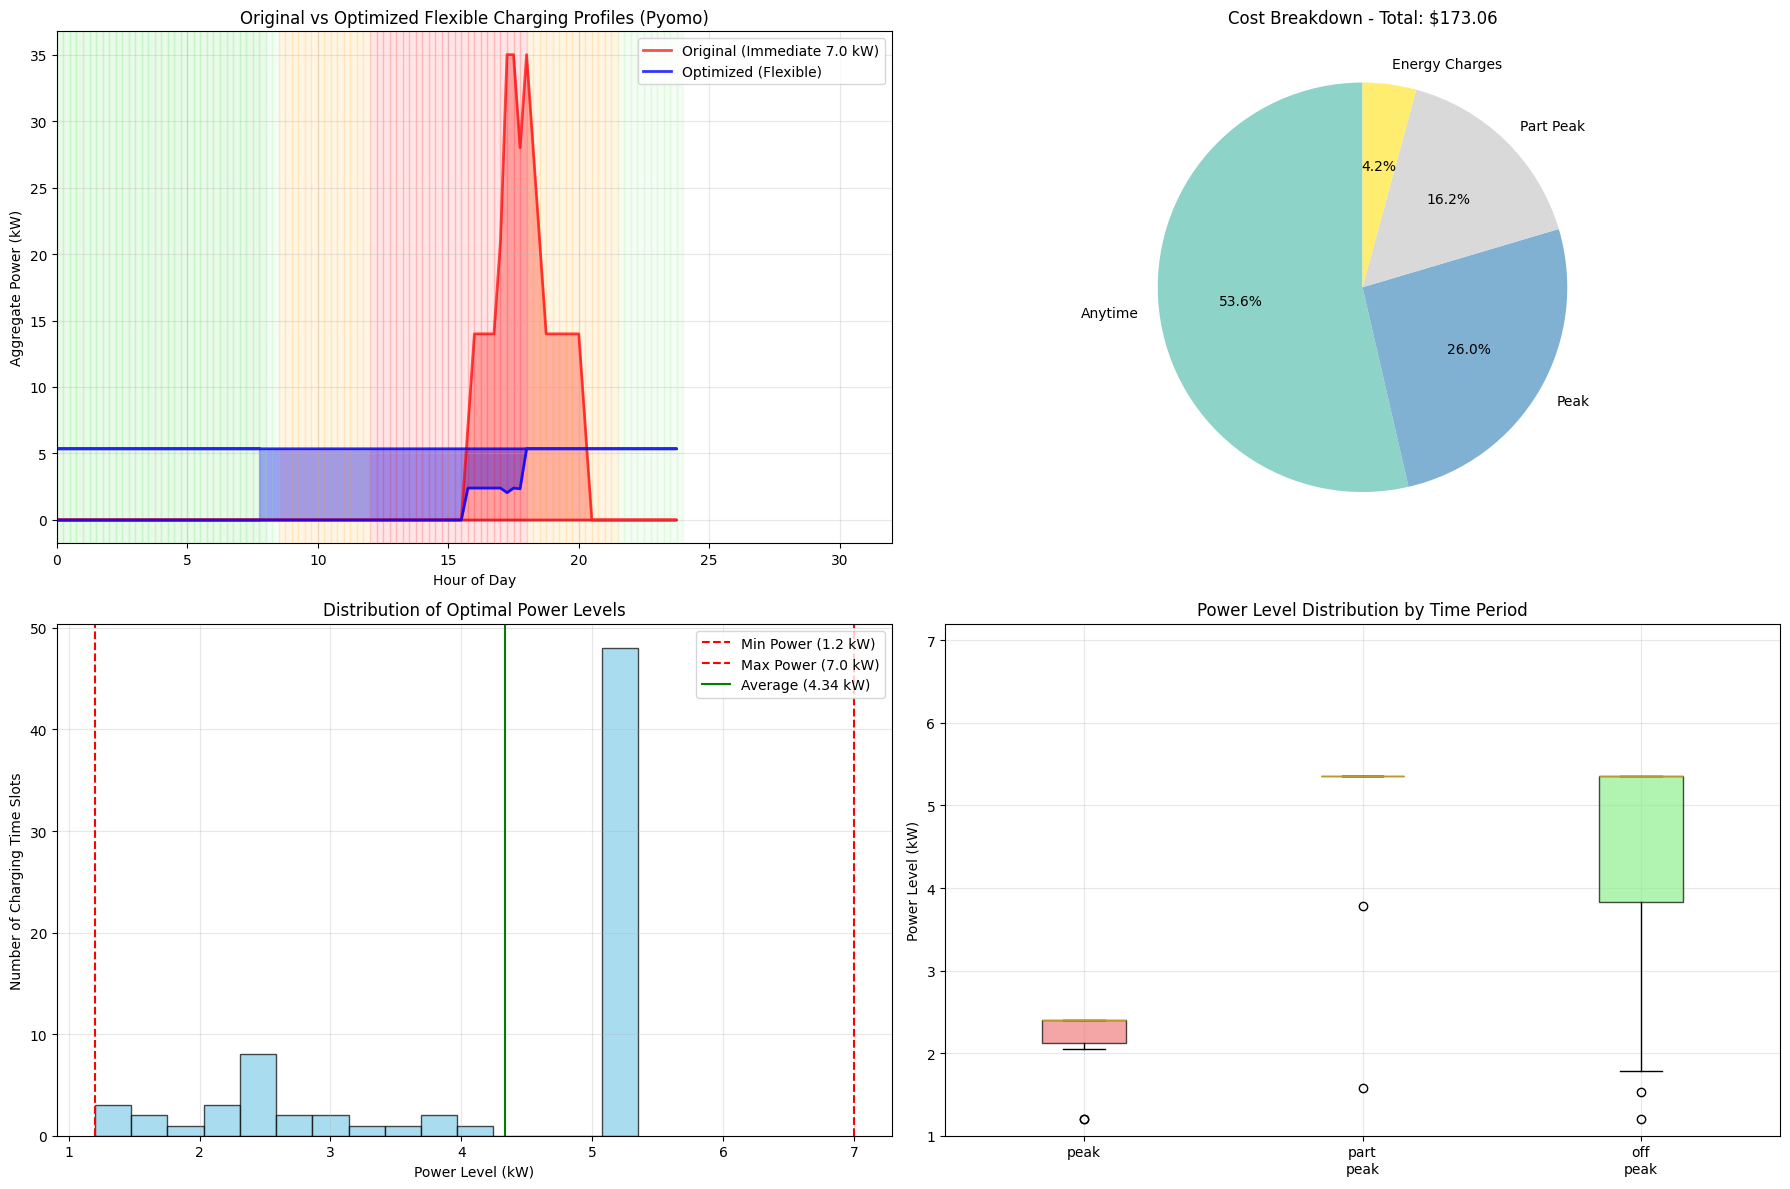


PYOMO FLEXIBLE CHARGING OPTIMIZATION RESULTS
Total Optimized Cost: $173.06

Load Profile Analysis:
Original Peak Demand: 35.0 kW
Optimized Peak Demand: 5.4 kW
Peak Reduction: 29.6 kW
Peak Reduction %: 84.7%

Power Level Statistics:
  Average Power: 4.34 kW
  Min Power Used: 1.20 kW
  Max Power Used: 5.35 kW
  Power Standard Deviation: 1.46 kW
  Total Energy Delivered: 80.25 kWh

Demand Charges by Period:
  Anytime: 5.35 kW @ $17.33/kW = $92.77
  Peak: 2.40 kW @ $18.74/kW = $44.98
  Part Peak: 5.35 kW @ $5.23/kW = $28.00

Energy Charges: $7.32

Optimal Flexible Charging Schedule:

Session 77344924 (7.2 kWh required):
  Charging from slot 79 to 100
  Earliest possible completion: Slot 81
  Actual completion: Slot 100
  Charging periods:
    19:45: 5.35 kW (part_peak, $0.1071/kWh)
    22:00: 2.15 kW (off_peak, $0.0806/kWh)
    22:30: 5.35 kW (off_peak, $0.0806/kWh)
    00:30: 5.35 kW (off_peak, $0.0806/kWh)
    00:45: 5.35 kW (off_peak, $0.0806/kWh)
    01:00: 5.35 kW (off_peak, $0.0806/

In [24]:
# Visualize Pyomo Optimization Results
if results['status'] == 'Optimal':
    # Create comprehensive visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 12))
    
    # Calculate time slots in hours for plotting
    time_slots_hours = [(optimizer.start_date + timedelta(minutes=15*i)).hour + 
                       (optimizer.start_date + timedelta(minutes=15*i)).minute/60 
                       for i in range(optimizer.total_time_slots)]
    
    # Original (uncontrolled) profile - immediate charging at maximum power
    original_profile = np.zeros(optimizer.total_time_slots)
    for _, session in demo_sessions.iterrows():
        start_slot = session['start_slot']
        slots_needed = session['min_slots_needed']
        
        # Immediate charging from arrival using maximum power
        for i in range(min(slots_needed, optimizer.total_time_slots - start_slot)):
            if start_slot + i < optimizer.total_time_slots:
                original_profile[start_slot + i] += 7.0  # Maximum power
    
    # Optimized flexible charging profile
    optimized_profile = np.zeros(optimizer.total_time_slots)
    power_levels_used = []
    
    for session_id in results['charging_schedule']:
        schedule = results['charging_schedule'][session_id]
        for charge_info in schedule:
            slot = charge_info['time_slot']
            power = charge_info['power_kw']
            optimized_profile[slot] += power
            power_levels_used.append(power)
    
    # Plot 1: Original vs Optimized Load Profiles
    ax1.plot(time_slots_hours, original_profile, 'r-', linewidth=2, 
             label='Original (Immediate 7.0 kW)', alpha=0.7)
    ax1.fill_between(time_slots_hours, original_profile, alpha=0.3, color='red')
    
    ax1.plot(time_slots_hours, optimized_profile, 'b-', linewidth=2, 
             label='Optimized (Flexible)', alpha=0.8)
    ax1.fill_between(time_slots_hours, optimized_profile, alpha=0.4, color='blue')
    
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Aggregate Power (kW)')
    ax1.set_title('Original vs Optimized Flexible Charging Profiles (Pyomo)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, 32)
    
    # Add time period background colors
    for i in range(len(time_slots_hours)):
        hour = time_slots_hours[i]
        time_slot = optimizer.start_date + timedelta(hours=hour)
        period = optimizer.get_time_period(time_slot)
        
        color_map = {'peak': 'red', 'part_peak': 'orange', 'off_peak': 'lightgreen'}
        if period in color_map:
            ax1.axvspan(hour, hour + 0.25, alpha=0.1, color=color_map[period])
    
    # Plot 2: Cost Breakdown
    periods = list(results['total_demand_by_period'].keys())
    demand_costs = [results['total_demand_by_period'][p] for p in periods]
    energy_cost = results['objective_value'] - sum(demand_costs)
    
    costs = demand_costs + [energy_cost]
    labels = [p.replace('_', ' ').title() for p in periods] + ['Energy Charges']
    colors = plt.cm.Set3(np.linspace(0, 1, len(costs)))
    
    # Filter out very small costs for better visualization
    filtered_costs = []
    filtered_labels = []
    filtered_colors = []
    for i, cost in enumerate(costs):
        if cost > 0.01:  # Only show costs > $0.01
            filtered_costs.append(cost)
            filtered_labels.append(labels[i])
            filtered_colors.append(colors[i])
    
    ax2.pie(filtered_costs, labels=filtered_labels, colors=filtered_colors, 
           autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'Cost Breakdown - Total: ${results["objective_value"]:.2f}')
    
    # Plot 3: Power Level Distribution (Histogram)
    if power_levels_used:
        ax3.hist(power_levels_used, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        ax3.set_xlabel('Power Level (kW)')
        ax3.set_ylabel('Number of Charging Time Slots')
        ax3.set_title('Distribution of Optimal Power Levels')
        ax3.axvline(optimizer.min_power, color='red', linestyle='--', 
                   label=f'Min Power ({optimizer.min_power} kW)')
        ax3.axvline(optimizer.max_power, color='red', linestyle='--', 
                   label=f'Max Power ({optimizer.max_power} kW)')
        ax3.axvline(np.mean(power_levels_used), color='green', linestyle='-', 
                   label=f'Average ({np.mean(power_levels_used):.2f} kW)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Power vs Time Period Analysis
    power_by_period = {'peak': [], 'part_peak': [], 'off_peak': []}
    
    for session_id in results['charging_schedule']:
        schedule = results['charging_schedule'][session_id]
        for charge_info in schedule:
            period = optimizer.get_time_period(charge_info['time'])
            if period in power_by_period:
                power_by_period[period].append(charge_info['power_kw'])
    
    # Create box plot for power levels by time period
    periods_with_data = [period for period in power_by_period if power_by_period[period]]
    power_data = [power_by_period[period] for period in periods_with_data]
    
    if power_data and any(len(data) > 0 for data in power_data):
        box_plot = ax4.boxplot(power_data, labels=[p.replace('_', '\n') for p in periods_with_data], 
                              patch_artist=True)
        
        # Color the boxes
        colors_box = ['lightcoral', 'lightsalmon', 'lightgreen']
        for patch, color in zip(box_plot['boxes'], colors_box[:len(box_plot['boxes'])]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        
        ax4.set_ylabel('Power Level (kW)')
        ax4.set_title('Power Level Distribution by Time Period')
        ax4.grid(True, alpha=0.3)
        ax4.set_ylim(optimizer.min_power - 0.2, optimizer.max_power + 0.2)
    else:
        # Fallback: simple power histogram
        if power_levels_used:
            ax4.hist(power_levels_used, bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            ax4.set_xlabel('Power Level (kW)')
            ax4.set_ylabel('Frequency')
            ax4.set_title('Power Level Distribution')
            ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*80)
    print("PYOMO FLEXIBLE CHARGING OPTIMIZATION RESULTS")
    print("="*80)
    
    print(f"Total Optimized Cost: ${results['objective_value']:.2f}")
    
    if np.max(original_profile) > 0:
        print(f"\nLoad Profile Analysis:")
        print(f"Original Peak Demand: {np.max(original_profile):.1f} kW")
        print(f"Optimized Peak Demand: {np.max(optimized_profile):.1f} kW")
        print(f"Peak Reduction: {np.max(original_profile) - np.max(optimized_profile):.1f} kW")
        print(f"Peak Reduction %: {((np.max(original_profile) - np.max(optimized_profile))/np.max(original_profile)*100):.1f}%")
    
    if power_levels_used:
        print(f"\nPower Level Statistics:")
        print(f"  Average Power: {np.mean(power_levels_used):.2f} kW")
        print(f"  Min Power Used: {np.min(power_levels_used):.2f} kW")
        print(f"  Max Power Used: {np.max(power_levels_used):.2f} kW")
        print(f"  Power Standard Deviation: {np.std(power_levels_used):.2f} kW")
        
        total_energy = sum(charge['energy_kwh'] for session_id in results['charging_schedule'] 
                          for charge in results['charging_schedule'][session_id])
        print(f"  Total Energy Delivered: {total_energy:.2f} kWh")
    
    print("\nDemand Charges by Period:")
    for period, cost in results['total_demand_by_period'].items():
        demand_kw = results['demand_charges'][period]
        rate = optimizer.demand_rates[period]
        print(f"  {period.replace('_', ' ').title()}: {demand_kw:.2f} kW @ ${rate:.2f}/kW = ${cost:.2f}")
    
    print(f"\nEnergy Charges: ${energy_cost:.2f}")
    
    print(f"\nOptimal Flexible Charging Schedule:")
    for session_id in results['charging_schedule']:
        session_info = demo_sessions[demo_sessions['event_id'] == session_id].iloc[0]
        schedule = results['charging_schedule'][session_id]
        schedule.sort(key=lambda x: x['time_slot'])
        
        print(f"\nSession {session_id} ({session_info['energy_kwh']:.1f} kWh required):")
        
        if schedule:
            first_charge_time = schedule[0]['time_slot']
            last_charge_time = schedule[-1]['time_slot']
            earliest_possible = session_info['min_completion_time']
            
            print(f"  Charging from slot {first_charge_time} to {last_charge_time}")
            print(f"  Earliest possible completion: Slot {earliest_possible}")
            print(f"  Actual completion: Slot {last_charge_time}")
            
            print(f"  Charging periods:")
            for i, charge_info in enumerate(schedule):
                power = charge_info['power_kw']
                time_str = charge_info['time'].strftime('%H:%M')
                period = optimizer.get_time_period(charge_info['time'])
                rate = optimizer.energy_rates[period]
                
                print(f"    {time_str}: {power:.2f} kW ({period}, ${rate:.4f}/kWh)")

else:
    print(f"Optimization failed with status: {results['status']}")
    print("Cannot generate visualizations")